In [94]:
from skimage import io
import matplotlib.pylab as plt
import numpy as np
from skimage.draw import line_nd
from skimage.util import img_as_float
from ipywidgets import interact, Dropdown, IntSlider, Layout, Checkbox
import glob

filename = "./images/Kropka.jpg"
test = io.imread(filename, as_gray=True)
test = img_as_float(test)

In [44]:
def radon_transform(image, scans = 360, detectors = 180, detectors_angular_span = 180, step = 1):
    image_center = (image.shape[0] // 2, image.shape[1] // 2)
    image_radius = max(image_center) * np.sqrt(2)

    radon_image = np.zeros((scans, detectors), dtype=image.dtype)

    detectors_angle = np.deg2rad(detectors_angular_span)
    detectors_gap = detectors_angle / (detectors - 1)

    for i in range(scans):
        emiter_angle = np.deg2rad((i * step) % 360)
        emiter_pos = (image_radius * np.cos(emiter_angle) + image_center[0], 
                      image_radius * np.sin(emiter_angle) + image_center[1])

        for j in range(detectors):
            detector_pos = (image_radius * (np.cos(emiter_angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[0],
                            image_radius * (np.sin(emiter_angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[1])
            
            y, x = line_nd(emiter_pos, detector_pos, endpoint=True)
            
            valid_mask = (y >= 0) & (y < image.shape[0]) & (x >= 0) & (x < image.shape[1])
            line = (y[valid_mask], x[valid_mask])

            if len(line[0]) > 0:
                radon_image[i, j] = np.average(image[line])
            else:
                radon_image[i, j] = 0

    return radon_image

C:\Users\kasia\AppData\Local\Temp\ipykernel_27576\3214133713.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(radon_image, cmap='gray')


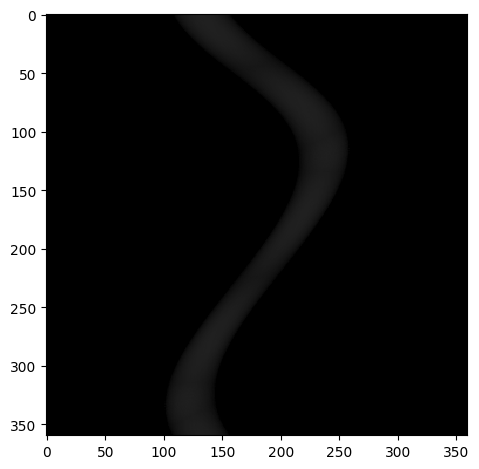

In [53]:
radon_image = radon_transform(test, scans=360, detectors=360, detectors_angular_span=180)
io.imshow(radon_image, cmap='gray')

In [57]:
def inverse_radon_transform(image, image_size, detectors_angular_span = 180, step = 1):
    reconstructed_image = np.zeros((image_size[0], image_size[1]), dtype=image.dtype)
    
    # get scans/detectors from image
    scans = image.shape[0]
    detectors = image.shape[1]

    image_center = (image_size[0] // 2, image_size[1] // 2)
    image_radius = max(image_center) * np.sqrt(2)

    detectors_angle = np.deg2rad(detectors_angular_span)
    detectors_gap = detectors_angle / (detectors - 1)

    for i in range(scans):
        emiter_angle = np.deg2rad((i * step) % 360)
        emiter_pos = (image_radius * np.cos(emiter_angle) + image_center[0], 
                      image_radius * np.sin(emiter_angle) + image_center[1])

        for j in range(detectors):
            detector_pos = (image_radius * (np.cos(emiter_angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[0],
                            image_radius * (np.sin(emiter_angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[1])
            
            y, x = line_nd(emiter_pos, detector_pos, endpoint=True)
            
            valid_mask = (y >= 0) & (y < image_size[0]) & (x >= 0) & (x < image_size[1])
            line = (y[valid_mask], x[valid_mask])

            if len(line[0]) > 0:
                reconstructed_image[line] += image[i, j]

    return reconstructed_image

C:\Users\kasia\AppData\Local\Temp\ipykernel_27576\511882632.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(inverse_radon_transform(radon_image, test.shape), cmap = 'gray')
c:\Users\kasia\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


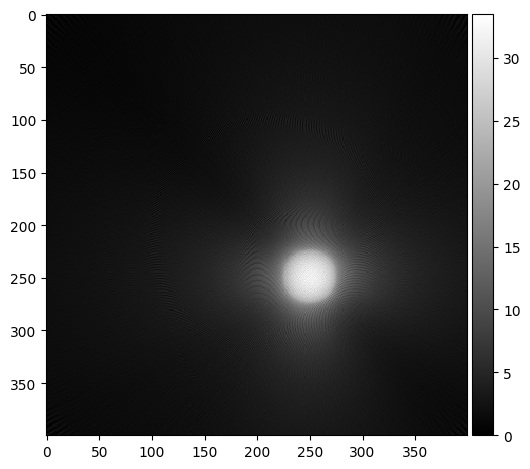

In [49]:
io.imshow(inverse_radon_transform(radon_image, test.shape), cmap = 'gray')

In [ ]:
def filter_sinogram(image, kernel_size):
    # make it odd
    if kernel_size % 2 == 0:
        kernel_size += 1

    kernel = np.zeros(kernel_size)
    kernel_center = kernel_size // 2
    kernel[kernel_center] = 1
    for i in range(kernel_center + 1, kernel_size, 2):
        val = (-4 / np.pi**2) / (i - kernel_center)**2
        kernel[i] = val
        kernel[-(i + 1)] = val

    filtered_image = image
    for i in range(image.shape[0]):
        filtered_image[i, :] = np.convolve(image[i, :], kernel, mode='same')
    return filtered_image

C:\Users\kasia\AppData\Local\Temp\ipykernel_27576\3851845783.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(inverse_radon_transform(filtered_image, test.shape), cmap='gray')


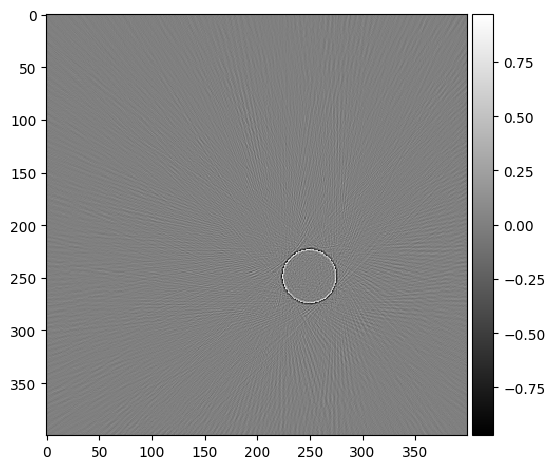

In [58]:
filtered_image = filter_sinogram(radon_image, 21)
io.imshow(inverse_radon_transform(filtered_image, test.shape), cmap='gray')

In [93]:
# global variables
selected_image_path = ""
scans = 360
detectors = 180
detectors_angular_span = 180
step = 1

is_filter = True

def set_parameters(image, s, d, arch, i):
    global selected_image_path, scans, detectors, detectors_angular_span, step
    selected_image_path = image
    scans = s
    detectors = d
    detectors_angular_span = arch
    step = i

def set_is_filter(val):
    global is_filter
    is_filter = val

In [ ]:
filenames = glob.glob(".\\images\\*.jpg")

interact(set_parameters,
         image=Dropdown(options=filenames, value='.\\images\\Kropka.jpg', description='Filename', layout=Layout(width='80%'), style={'description_width': '200px'}),
         s=IntSlider(value=360, min=180, max=720, step=30, description='Amount of scans/emiters:', layout=Layout(width='80%'), style={'description_width': '200px'}),
         d=IntSlider(value=180, min=90, max=720, step=30, description='Amount of detectors:', layout=Layout(width='80%'), style={'description_width': '200px'}),
         arch=IntSlider(value=180, min=90, max=360, step=10, description='Detectors angular span:', layout=Layout(width='80%'), style={'description_width': '200px'}),
         i=IntSlider(value=1, min=1, max=10, step=1, description='Emiter-detectors rotate steps:', layout=Layout(width='80%'), style={'description_width': '200px'})
)

interact(set_is_filter, val=Checkbox(value=True, description='Sinogram filtering'))

interactive(children=(Dropdown(description='Filename', index=3, layout=Layout(width='80%'), options=('.\\image…

interactive(children=(Checkbox(value=True, description='Sinogram filtering'), Output()), _dom_classes=('widget…

<function __main__.set_is_filter(val)>